## Importation des librairies

In [666]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from scipy import spatial,stats
import missingno as msno
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import bartlett
from scipy.stats import shapiro
from scipy.stats import kstest
from scipy.stats import f_oneway
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.decomposition import PCA
import qrcode
import warnings
warnings.filterwarnings('ignore')


## Chargement du fichier source

In [667]:
data_food= pd.read_csv("fr.openfoodfacts.org.products.csv", sep='\t')
data_food.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,3087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,4559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,16087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,16094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Nombres de lignes, de colonnes et affichage des différentes colonnes

In [668]:
print('lignes:',data_food.shape[0],'colonnes:',data_food.shape[1])

lignes: 320772 colonnes: 162


### Taux de remplissage des colonnes et sélection des colonnes ayant plus de 40% de remplissage

In [669]:
def select_columns_with_fill_rate(dataframe, threshold):
    # Calcul du taux de remplissage pour chaque colonne
    fill_rates = dataframe.count() / len(dataframe) * 100
    
    # Sélection des colonnes avec un taux de remplissage supérieur au seuil
    selected_columns = fill_rates[fill_rates > threshold].index.tolist()
    
    return dataframe[selected_columns]

threshold = 40  

data_plus_40 = select_columns_with_fill_rate(data_food, threshold)
data_plus_40

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,brands,brands_tags,...,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
0,3087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,Ferme t'y R'nao,ferme-t-y-r-nao,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,3.6,3.57,0.00000,0.000,0.0,0.0214,0.000,0.00129,14.0,14.0
2,4559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,Torn & Glasser,torn-glasser,...,7.1,17.86,0.63500,0.250,0.0,0.0000,0.071,0.00129,0.0,0.0
3,16087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,Grizzlies,grizzlies,...,7.1,17.86,1.22428,0.482,NaN,NaN,0.143,0.00514,12.0,12.0
4,16094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,Bob's Red Mill,bob-s-red-mill,...,5.7,8.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320767,9948282780603,http://world-fr.openfoodfacts.org/produit/9948...,openfoodfacts-contributors,1490631299,2017-03-27T16:14:59Z,1491244498,2017-04-03T18:34:58Z,Tomato & ricotta,Panzani,panzani,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320768,99567453,http://world-fr.openfoodfacts.org/produit/9956...,usda-ndb-import,1489059076,2017-03-09T11:31:16Z,1491244499,2017-04-03T18:34:59Z,"Mint Melange Tea A Blend Of Peppermint, Lemon ...",Trader Joe's,trader-joe-s,...,0.0,0.00,0.00000,0.000,0.0,0.0000,0.000,0.00000,0.0,0.0
320769,9970229501521,http://world-fr.openfoodfacts.org/produit/9970...,tomato,1422099377,2015-01-24T11:36:17Z,1491244499,2017-04-03T18:34:59Z,乐吧泡菜味薯片,乐吧,乐吧,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320770,9980282863788,http://world-fr.openfoodfacts.org/produit/9980...,openfoodfacts-contributors,1492340089,2017-04-16T10:54:49Z,1492340089,2017-04-16T10:54:49Z,Tomates aux Vermicelles,Knorr,knorr,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Suppression des lignes Nan dans product_name

In [670]:
data_plus_40['product_name'].isna().sum()

17762

In [671]:
data_plus_40 = data_plus_40.dropna(subset=['product_name'])


### Suppression des lignes où il n'y a que des données Nan dans les colonnes chiffrées

In [672]:
cols = data_plus_40.select_dtypes(include = ['int32','float64']).columns
food = data_plus_40.dropna(subset=cols, how='all')
food

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,brands,brands_tags,...,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
1,4530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,3.6,3.57,0.00000,0.000,0.0,0.0214,0.000,0.00129,14.0,14.0
2,4559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,Torn & Glasser,torn-glasser,...,7.1,17.86,0.63500,0.250,0.0,0.0000,0.071,0.00129,0.0,0.0
3,16087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,Grizzlies,grizzlies,...,7.1,17.86,1.22428,0.482,NaN,NaN,0.143,0.00514,12.0,12.0
4,16094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,Bob's Red Mill,bob-s-red-mill,...,5.7,8.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,16100,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055651,2017-03-09T10:34:11Z,1489055651,2017-03-09T10:34:11Z,Breadshop Honey Gone Nuts Granola,Unfi,unfi,...,7.7,13.46,NaN,NaN,NaN,NaN,0.038,0.00346,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320758,9900010011557,http://world-fr.openfoodfacts.org/produit/9900...,jeanbono,1375778997,2013-08-06T08:49:57Z,1379091297,2013-09-13T16:54:57Z,Miel de Camargue,L. Boulaire,l-boulaire,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320763,99111250,http://world-fr.openfoodfacts.org/produit/9911...,balooval,1367163039,2013-04-28T15:30:39Z,1371690556,2013-06-20T01:09:16Z,Thé vert Earl grey,Lobodis,lobodis,...,0.2,0.50,0.02540,0.010,NaN,NaN,NaN,NaN,2.0,0.0
320765,9935010000003,http://world-fr.openfoodfacts.org/produit/9935...,sebleouf,1446293229,2015-10-31T12:07:09Z,1446376839,2015-11-01T11:20:39Z,Rillette d'oie,"Sans marque,D.Lambert","sans-marque,d-lambert",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320768,99567453,http://world-fr.openfoodfacts.org/produit/9956...,usda-ndb-import,1489059076,2017-03-09T11:31:16Z,1491244499,2017-04-03T18:34:59Z,"Mint Melange Tea A Blend Of Peppermint, Lemon ...",Trader Joe's,trader-joe-s,...,0.0,0.00,0.00000,0.000,0.0,0.0000,0.000,0.00000,0.0,0.0


### Création d'une colonne pour le taux de remplissage des lignes dans les colonnes chiffrées

In [673]:
def calcul_taux_remplissage_ligne(row):
    total_columns = len(row)
    filled_columns = row.count()
    fill_rate = filled_columns / total_columns * 100
    return fill_rate
food['taux de remplissage par ligne'] = food.apply(calcul_taux_remplissage_ligne, axis=1)

food = food[food['taux de remplissage par ligne'] >= 40]

In [674]:
food

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,brands,brands_tags,...,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,taux de remplissage par ligne
1,4530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,3.57,0.00000,0.000,0.0,0.0214,0.000,0.00129,14.0,14.0,90.476190
2,4559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,Torn & Glasser,torn-glasser,...,17.86,0.63500,0.250,0.0,0.0000,0.071,0.00129,0.0,0.0,95.238095
3,16087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,Grizzlies,grizzlies,...,17.86,1.22428,0.482,NaN,NaN,0.143,0.00514,12.0,12.0,85.714286
4,16094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,Bob's Red Mill,bob-s-red-mill,...,8.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.285714
5,16100,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055651,2017-03-09T10:34:11Z,1489055651,2017-03-09T10:34:11Z,Breadshop Honey Gone Nuts Granola,Unfi,unfi,...,13.46,NaN,NaN,NaN,NaN,0.038,0.00346,NaN,NaN,73.809524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320758,9900010011557,http://world-fr.openfoodfacts.org/produit/9900...,jeanbono,1375778997,2013-08-06T08:49:57Z,1379091297,2013-09-13T16:54:57Z,Miel de Camargue,L. Boulaire,l-boulaire,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.000000
320763,99111250,http://world-fr.openfoodfacts.org/produit/9911...,balooval,1367163039,2013-04-28T15:30:39Z,1371690556,2013-06-20T01:09:16Z,Thé vert Earl grey,Lobodis,lobodis,...,0.50,0.02540,0.010,NaN,NaN,NaN,NaN,2.0,0.0,78.571429
320765,9935010000003,http://world-fr.openfoodfacts.org/produit/9935...,sebleouf,1446293229,2015-10-31T12:07:09Z,1446376839,2015-11-01T11:20:39Z,Rillette d'oie,"Sans marque,D.Lambert","sans-marque,d-lambert",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.000000
320768,99567453,http://world-fr.openfoodfacts.org/produit/9956...,usda-ndb-import,1489059076,2017-03-09T11:31:16Z,1491244499,2017-04-03T18:34:59Z,"Mint Melange Tea A Blend Of Peppermint, Lemon ...",Trader Joe's,trader-joe-s,...,0.00,0.00000,0.000,0.0,0.0000,0.000,0.00000,0.0,0.0,95.238095


## Choix des indicateurs en supprimant celles non nécessaires à mon choix d'application

### Pour ce choix d'indicateurs je choisis des informations qui concernent l'apport nutritionnel des sportifs et on estime que le régime idéal du sportif, se compose de 45 % à 65 % de glucides, de 10 % à 30 % de protéines et de 25 % à 35 % de matières grasses. Je vais donc concerver uniquement les colonnes concernées

In [675]:
col_keep = ['product_name','energy_100g','fat_100g','carbohydrates_100g','sugars_100g','proteins_100g',
            'nutrition-score-fr_100g']
def select_columns(dataframe, col_keep):
    selected_data = dataframe.loc[:, col_keep]
    return selected_data
food = select_columns(food, col_keep)
food

,product_name,energy_100g,fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,nutrition-score-fr_100g
1,Banana Chips Sweetened (Whole),2243.0,28.57,64.29,14.29,3.57,14.0
2,Peanuts,1941.0,17.86,60.71,17.86,17.86,0.0
3,Organic Salted Nut Mix,2540.0,57.14,17.86,3.57,17.86,12.0
4,Organic Polenta,1552.0,1.43,77.14,NaN,8.57,NaN
5,Breadshop Honey Gone Nuts Granola,1933.0,18.27,63.46,11.54,13.46,NaN
...,...,...,...,...,...,...,...
320758,Miel de Camargue,NaN,NaN,NaN,NaN,NaN,NaN
320763,Thé vert Earl grey,21.0,0.20,0.50,0.50,0.50,2.0
320765,Rillette d'oie,NaN,NaN,NaN,NaN,NaN,NaN
320768,"Mint Melange Tea A Blend Of Peppermint, Lemon ...",0.0,0.00,0.00,0.00,0.00,0.0


In [676]:
food.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272543 entries, 1 to 320771
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   product_name             272543 non-null  object 
 1   energy_100g              257740 non-null  float64
 2   fat_100g                 240578 non-null  float64
 3   carbohydrates_100g       240267 non-null  float64
 4   sugars_100g              241910 non-null  float64
 5   proteins_100g            256601 non-null  float64
 6   nutrition-score-fr_100g  218463 non-null  float64
dtypes: float64(6), object(1)
memory usage: 16.6+ MB


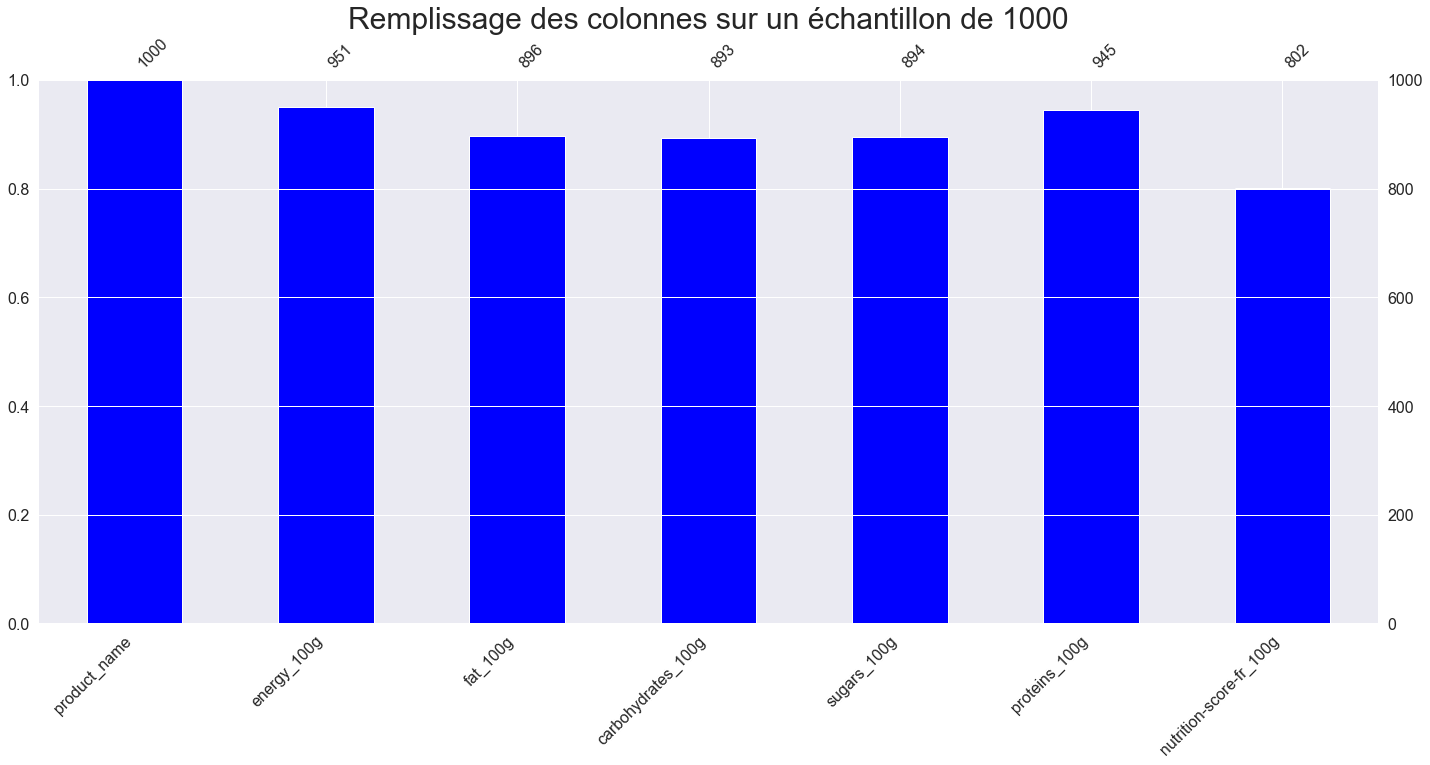

In [677]:
msno.bar(food.sample(1000),color='blue')
plt.title('Remplissage des colonnes sur un échantillon de 1000',size=30)
plt.show()

### Suppression des doublons

In [678]:
duplicates = food[food.duplicated()]
duplicates

,product_name,energy_100g,fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,nutrition-score-fr_100g
152,Peanuts,1941.0,17.86,60.71,17.86,17.86,0.0
223,Luxury Christmas Pudding,1284.0,7.00,54.20,44.00,3.90,10.0
324,"The Madelaine Chocolate Company, Solid Milk Ch...",2326.0,33.33,58.33,55.56,8.33,23.0
358,"Emojeez, Gummies Candy, Fruit",1151.0,0.00,67.50,40.00,5.00,11.0
385,"Pb&J Trail Mix, Grape",1971.0,25.88,51.76,44.71,9.41,19.0
...,...,...,...,...,...,...,...
320732,Taco Seasoning Mix,1393.0,0.00,66.67,16.67,16.67,NaN
320736,Attiéké,NaN,NaN,NaN,NaN,NaN,NaN
320743,Gingembre,NaN,NaN,NaN,NaN,NaN,NaN
320753,Lager,NaN,NaN,NaN,NaN,NaN,NaN


In [679]:
food = food.drop_duplicates()
food

,product_name,energy_100g,fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,nutrition-score-fr_100g
1,Banana Chips Sweetened (Whole),2243.0,28.57,64.29,14.29,3.57,14.0
2,Peanuts,1941.0,17.86,60.71,17.86,17.86,0.0
3,Organic Salted Nut Mix,2540.0,57.14,17.86,3.57,17.86,12.0
4,Organic Polenta,1552.0,1.43,77.14,NaN,8.57,NaN
5,Breadshop Honey Gone Nuts Granola,1933.0,18.27,63.46,11.54,13.46,NaN
...,...,...,...,...,...,...,...
320758,Miel de Camargue,NaN,NaN,NaN,NaN,NaN,NaN
320763,Thé vert Earl grey,21.0,0.20,0.50,0.50,0.50,2.0
320765,Rillette d'oie,NaN,NaN,NaN,NaN,NaN,NaN
320768,"Mint Melange Tea A Blend Of Peppermint, Lemon ...",0.0,0.00,0.00,0.00,0.00,0.0


### Distribution des données de l'energy_100g avant toute manipulation

In [680]:
food.describe()

,energy_100g,fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,nutrition-score-fr_100g
count,2.354780e+05,218404.000000,218100.000000,222423.000000,234358.000000,202154.000000
mean,1.144503e+03,12.520457,32.524478,15.961283,7.160610,9.203681
std,6.778043e+03,16.716759,29.584239,22.169376,8.376911,9.025648
min,0.000000e+00,0.000000,0.000000,-17.860000,-800.000000,-15.000000
25%,3.970000e+02,0.100000,6.500000,1.400000,0.810000,1.000000
50%,1.101000e+03,5.360000,21.805000,5.880000,5.000000,10.000000
75%,1.674000e+03,20.000000,58.700000,24.200000,10.000000,16.000000
max,3.251373e+06,714.290000,2916.670000,3520.000000,430.000000,40.000000


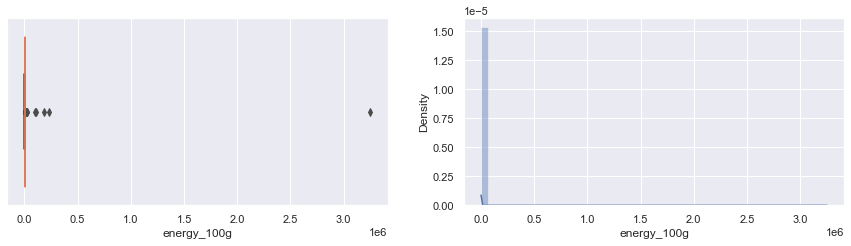

In [681]:
plt.figure(figsize = (15, 20))
plt.subplot(5,2,1)
sns.boxplot( x=food['energy_100g'],boxprops={"facecolor": (.4, .6, .8, .5)},medianprops={"color": "coral"})
plt.subplot(5,2,2)
sns.distplot(food['energy_100g'])
plt.show()

In [682]:
Q1 = food['energy_100g'].quantile(0.25)
Q2 = food['energy_100g'].quantile(0.50)
Q3 = food['energy_100g'].quantile(0.75)
IQR =  (Q3 - Q1)
limite_haute = (Q3 + 1.5 * IQR)
print("le 1er quartile se situe à",Q1)
print("le 2ème quartile se situe à",Q2)
print("le 3ème quartile se situe à",Q3)
print("l'écart interquartile est de",IQR)
print("la limite haute est de",limite_haute)

le 1er quartile se situe à 397.0
le 2ème quartile se situe à 1101.0
le 3ème quartile se situe à 1674.0
l'écart interquartile est de 1277.0
la limite haute est de 3589.5


In [683]:
food['energy_100g'].where(food['energy_100g']>limite_haute).count()

949

### distribution des données de energy_100 une fois les outliers exclus

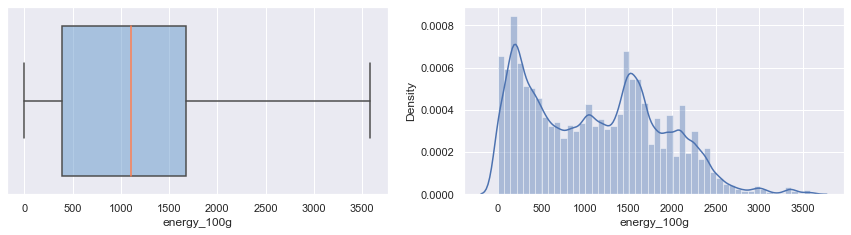

In [684]:
energy_filter = food['energy_100g'].where(food['energy_100g']<=limite_haute)
plt.figure(figsize = (15, 20))
plt.subplot(5,2,1)
sns.boxplot(x=energy_filter,boxprops={"facecolor": (.4, .6, .8, .5)},medianprops={"color": "coral"})
plt.subplot(5,2,2)
sns.distplot(energy_filter)
plt.show()

In [685]:
food.loc[food["energy_100g"] > limite_haute ,"energy_100g" ] = np.nan

In [686]:
food.describe()

,energy_100g,fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,nutrition-score-fr_100g
count,234529.000000,218404.000000,218100.000000,222423.000000,234358.000000,202154.000000
mean,1116.153601,12.520457,32.524478,15.961283,7.160610,9.203681
std,764.724738,16.716759,29.584239,22.169376,8.376911,9.025648
min,0.000000,0.000000,0.000000,-17.860000,-800.000000,-15.000000
25%,393.000000,0.100000,6.500000,1.400000,0.810000,1.000000
50%,1100.000000,5.360000,21.805000,5.880000,5.000000,10.000000
75%,1674.000000,20.000000,58.700000,24.200000,10.000000,16.000000
max,3586.000000,714.290000,2916.670000,3520.000000,430.000000,40.000000


In [687]:
food_modif = food.copy()
food_modif = food_modif.drop('product_name',axis=1)

In [688]:
food_modif.isna().sum()

energy_100g                14128
fat_100g                   30253
carbohydrates_100g         30557
sugars_100g                26234
proteins_100g              14299
nutrition-score-fr_100g    46503
dtype: int64

In [689]:

food_modif.describe()

,energy_100g,fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,nutrition-score-fr_100g
count,234529.000000,218404.000000,218100.000000,222423.000000,234358.000000,202154.000000
mean,1116.153601,12.520457,32.524478,15.961283,7.160610,9.203681
std,764.724738,16.716759,29.584239,22.169376,8.376911,9.025648
min,0.000000,0.000000,0.000000,-17.860000,-800.000000,-15.000000
25%,393.000000,0.100000,6.500000,1.400000,0.810000,1.000000
50%,1100.000000,5.360000,21.805000,5.880000,5.000000,10.000000
75%,1674.000000,20.000000,58.700000,24.200000,10.000000,16.000000
max,3586.000000,714.290000,2916.670000,3520.000000,430.000000,40.000000


### Remplacement des valeurs supérieures à 100 par Nan pour certaines colonnes

In [690]:
col_nan=["fat_100g","carbohydrates_100g","sugars_100g","proteins_100g"]
food_modif[col_nan] = food_modif[col_nan].applymap(lambda x: np.nan if x > 100 else x)

In [691]:
food_modif.isna().sum()

energy_100g                14128
fat_100g                   30257
carbohydrates_100g         30574
sugars_100g                26244
proteins_100g              14300
nutrition-score-fr_100g    46503
dtype: int64

### Remplacement des valeurs inférieures à 0 par Nan pour certaines colonnes

In [692]:
food_modif[col_nan] = food_modif[col_nan].applymap(lambda x: np.nan if x <0 else x)

In [693]:
food_modif.isna().sum()

energy_100g                14128
fat_100g                   30257
carbohydrates_100g         30574
sugars_100g                26251
proteins_100g              14303
nutrition-score-fr_100g    46503
dtype: int64

In [694]:
food_modif.describe()

,energy_100g,fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,nutrition-score-fr_100g
count,234529.000000,218400.000000,218083.000000,222406.000000,234354.000000,202154.000000
mean,1116.153601,12.514733,32.504318,15.942191,7.164460,9.203681
std,764.724738,16.628495,28.920916,20.877819,8.095235,9.025648
min,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000
25%,393.000000,0.100000,6.500000,1.400000,0.810000,1.000000
50%,1100.000000,5.360000,21.800000,5.880000,5.000000,10.000000
75%,1674.000000,20.000000,58.700000,24.200000,10.000000,16.000000
max,3586.000000,100.000000,100.000000,100.000000,100.000000,40.000000


In [695]:
food_modif.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 248657 entries, 1 to 320771
Data columns (total 6 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   energy_100g              234529 non-null  float64
 1   fat_100g                 218400 non-null  float64
 2   carbohydrates_100g       218083 non-null  float64
 3   sugars_100g              222406 non-null  float64
 4   proteins_100g            234354 non-null  float64
 5   nutrition-score-fr_100g  202154 non-null  float64
dtypes: float64(6)
memory usage: 13.3 MB


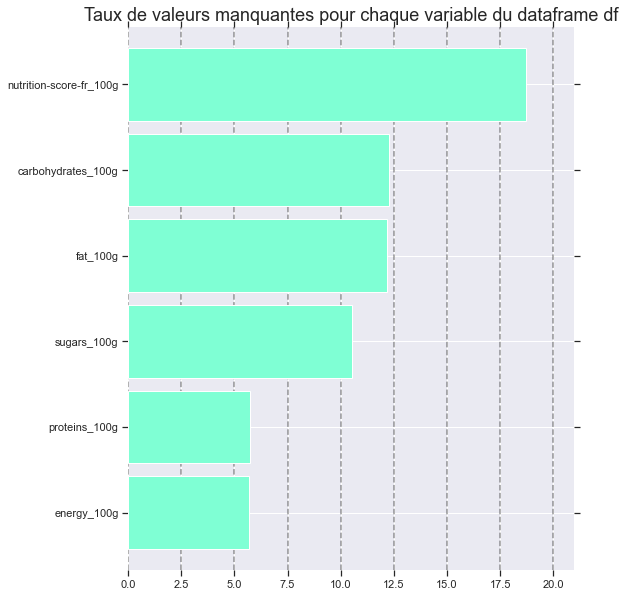

In [696]:
size = food_modif.shape
nan_values = food_modif.isna().sum()

nan_values = nan_values.sort_values(ascending=True)*100/size[0]

ax = nan_values.plot(kind='barh', 
                     figsize=(8, 10), 
                     color='aquamarine',
                     zorder=2,
                     width=0.85)

ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.tick_params(axis="both", 
               which="both", 
               bottom="off", 
               top="off", 
               labelbottom="on", 
               left="off", 
               right="off", 
               labelleft="on")
ax.set_title("Taux de valeurs manquantes pour chaque variable du dataframe df",size=18)
vals = ax.get_xticks()

for tick in vals:
  ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='black', zorder=1)

### Distribution des données avant toute imputation

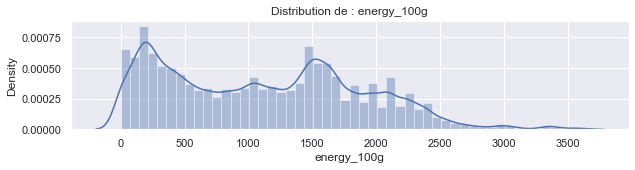

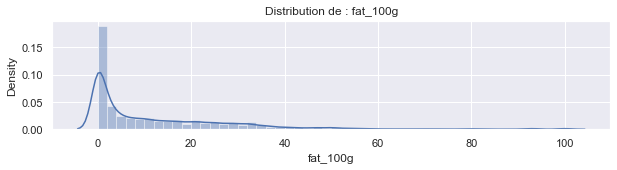

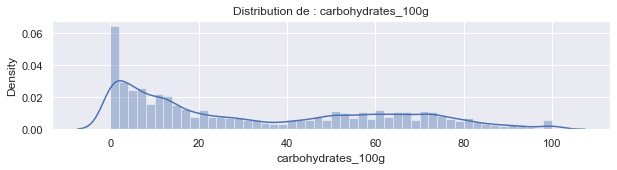

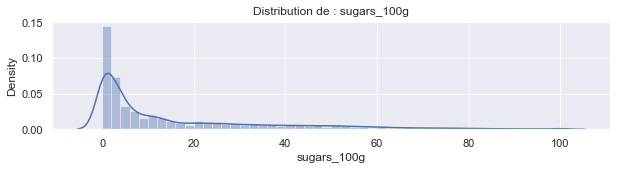

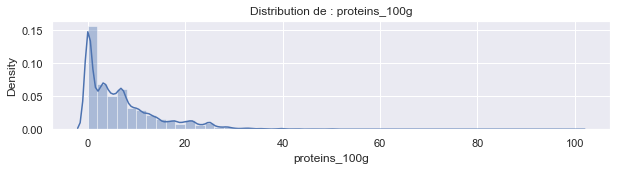

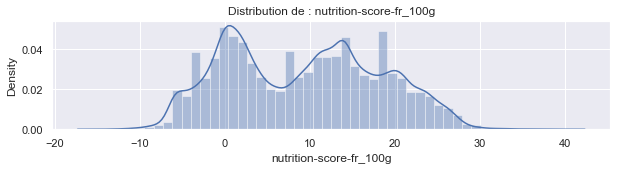

In [697]:
numeric_columns = food_modif.select_dtypes(include = ['int32','float64']).columns
for column in numeric_columns:
    plt.figure(figsize = (10,2))
    sns.set(font_scale=1)
    sns.distplot(food_modif[column], bins=50)
    chaine = 'Distribution de : ' + column
    plt.title(chaine)
    plt.xlabel(column)
    plt.show()

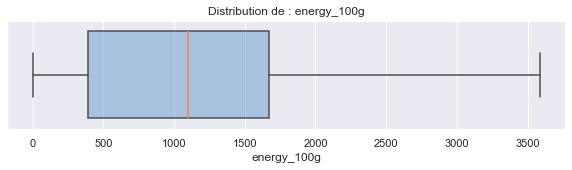

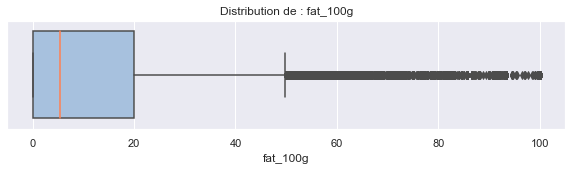

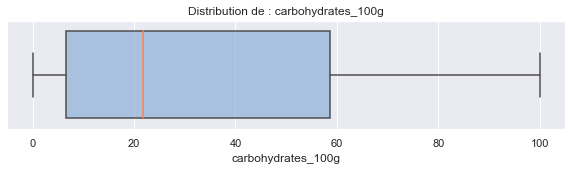

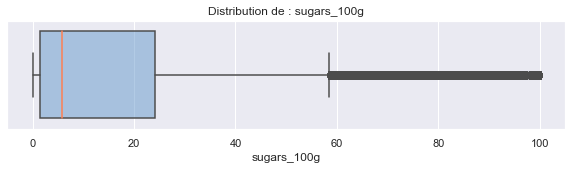

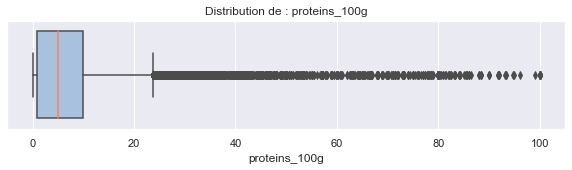

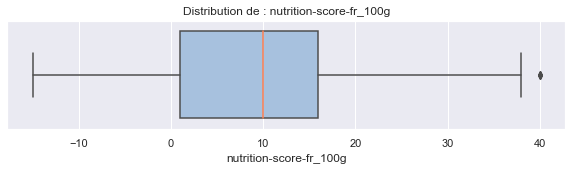

In [698]:
numeric_columns = food_modif.select_dtypes(include = ['int32','float64']).columns
for column in numeric_columns:
    plt.figure(figsize = (10,2))
    sns.set(font_scale=1)
    sns.boxplot(x=food_modif[column],boxprops={"facecolor": (.4, .6, .8, .5)},medianprops={"color": "coral"})
    chaine = 'Distribution de : ' + column
    plt.title(chaine)
    plt.xlabel(column)
    plt.show()

## Imputation des valeurs par KNN

In [699]:
scaler = StandardScaler().fit(food_modif)
scaled= scaler.transform(food_modif)

In [700]:
imputer = KNNImputer(n_neighbors=5)
knn = imputer.fit_transform(scaled)

In [701]:
inverse_food_modif = scaler.inverse_transform(knn)
inverse_food_modif

array([[2243.        ,   28.57      ,   64.29      ,   14.29      ,
           3.57      ,   14.        ],
       [1941.        ,   17.86      ,   60.71      ,   17.86      ,
          17.86      ,    0.        ],
       [2540.        ,   57.14      ,   17.86      ,    3.57      ,
          17.86      ,   12.        ],
       ...,
       [1116.15360145,   12.514733  ,   32.50431809,   15.94219125,
           7.16445981,    9.20368135],
       [   0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ],
       [2092.        ,    0.        ,    0.        ,    0.        ,
           0.        ,   16.8       ]])

In [702]:
food_modif_knn = pd.DataFrame(inverse_food_modif, columns=food_modif.columns, index=food_modif.index)
food_modif_knn

,energy_100g,fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,nutrition-score-fr_100g
1,2243.000000,28.570000,64.290000,14.290000,3.57000,14.000000
2,1941.000000,17.860000,60.710000,17.860000,17.86000,0.000000
3,2540.000000,57.140000,17.860000,3.570000,17.86000,12.000000
4,1552.000000,1.430000,77.140000,3.860000,8.57000,4.200000
5,1933.000000,18.270000,63.460000,11.540000,13.46000,4.400000
...,...,...,...,...,...,...
320758,1116.153601,12.514733,32.504318,15.942191,7.16446,9.203681
320763,21.000000,0.200000,0.500000,0.500000,0.50000,2.000000
320765,1116.153601,12.514733,32.504318,15.942191,7.16446,9.203681
320768,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000


In [703]:
food_modif_knn.isna().sum()

energy_100g                0
fat_100g                   0
carbohydrates_100g         0
sugars_100g                0
proteins_100g              0
nutrition-score-fr_100g    0
dtype: int64

In [704]:
food_modif_knn.describe()

,energy_100g,fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,nutrition-score-fr_100g
count,248657.000000,248657.000000,248657.000000,248657.000000,248657.000000,248657.000000
mean,1120.217846,12.852827,32.076839,15.471791,7.159461,9.333652
std,751.043567,16.516037,27.748802,20.040663,7.881135,8.625252
min,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000
25%,418.000000,0.410000,6.970000,1.330000,1.000000,2.000000
50%,1116.153601,7.140000,25.000000,6.670000,5.400000,9.203681
75%,1644.000000,19.640000,56.000000,21.430000,10.000000,16.000000
max,3586.000000,100.000000,100.000000,100.000000,100.000000,40.000000


### Distribution des données après imputation par le KNN

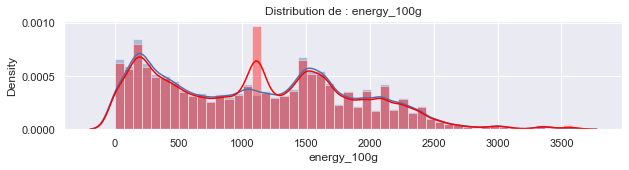

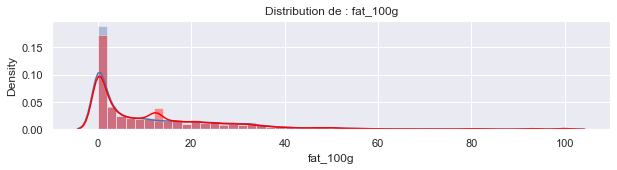

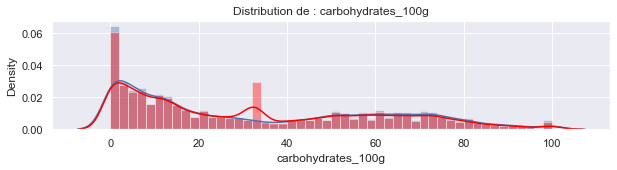

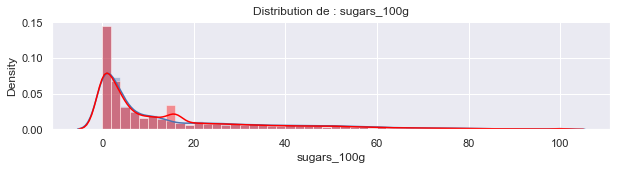

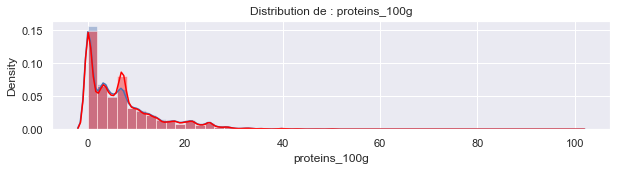

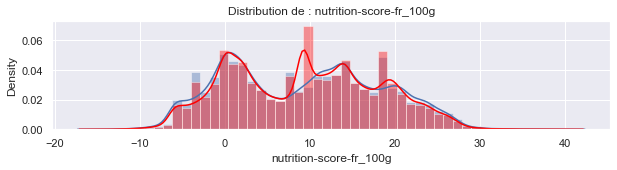

In [705]:
numeric_columns = food_modif.select_dtypes(include = ['int32','float64']).columns
for column in numeric_columns:
    plt.figure(figsize = (10,2))
    sns.set(font_scale=1)
    sns.distplot(food_modif[column], bins=50)
    sns.distplot(food_modif_knn[column], bins=50,color= 'red')
    chaine = 'Distribution de : ' + column
    plt.title(chaine)
    plt.xlabel(column)
    plt.show()

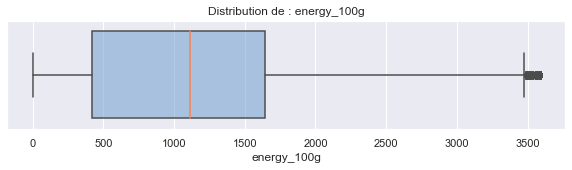

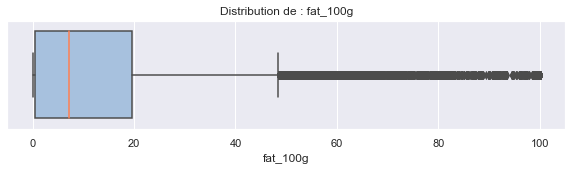

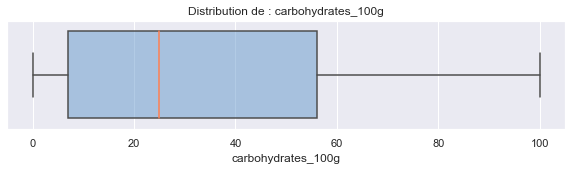

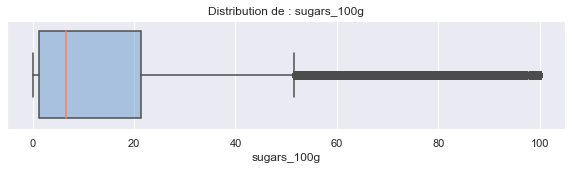

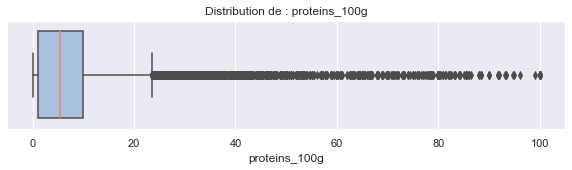

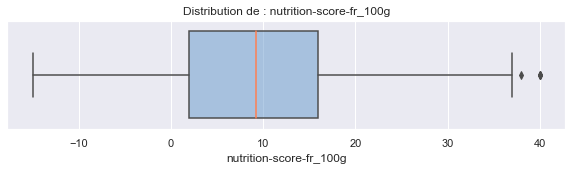

In [706]:
numeric_columns = food_modif_knn.select_dtypes(include = ['int32','float64']).columns
for column in numeric_columns:
    plt.figure(figsize = (10,2))
    sns.set(font_scale=1)
    sns.boxplot(x=food_modif_knn[column],boxprops={"facecolor": (.4, .6, .8, .5)},medianprops={"color": "coral"})
    chaine = 'Distribution de : ' + column
    plt.title(chaine)
    plt.xlabel(column)
    plt.show()

## Imputation par Interative Imputer

In [707]:
iterimp = IterativeImputer()
iter_imp = iterimp.fit_transform(scaled)
iter_imp

array([[ 1.47353517e+00,  9.65529601e-01,  1.09905769e+00,
        -7.91363762e-02, -4.44022612e-01,  5.31411214e-01],
       [ 1.07862099e+00,  3.21452985e-01,  9.75271564e-01,
         9.18588777e-02,  1.32121708e+00, -1.01972780e+00],
       [ 1.86191104e+00,  2.68366862e+00, -5.06358508e-01,
        -5.92601116e-01,  1.32121708e+00,  3.09819926e-01],
       ...,
       [ 1.08566237e-02, -1.57071075e-03, -3.82710308e-03,
        -1.93763100e-02, -7.56093481e-04, -2.03071121e-02],
       [-1.45955260e+00, -7.52609419e-01, -1.12390607e+00,
        -7.63596370e-01, -8.85023711e-01, -1.01972780e+00],
       [ 1.27607808e+00, -7.52609419e-01, -1.12390607e+00,
        -7.63596370e-01, -8.85023711e-01,  7.04931569e-01]])

In [708]:
iter_imp

array([[ 1.47353517e+00,  9.65529601e-01,  1.09905769e+00,
        -7.91363762e-02, -4.44022612e-01,  5.31411214e-01],
       [ 1.07862099e+00,  3.21452985e-01,  9.75271564e-01,
         9.18588777e-02,  1.32121708e+00, -1.01972780e+00],
       [ 1.86191104e+00,  2.68366862e+00, -5.06358508e-01,
        -5.92601116e-01,  1.32121708e+00,  3.09819926e-01],
       ...,
       [ 1.08566237e-02, -1.57071075e-03, -3.82710308e-03,
        -1.93763100e-02, -7.56093481e-04, -2.03071121e-02],
       [-1.45955260e+00, -7.52609419e-01, -1.12390607e+00,
        -7.63596370e-01, -8.85023711e-01, -1.01972780e+00],
       [ 1.27607808e+00, -7.52609419e-01, -1.12390607e+00,
        -7.63596370e-01, -8.85023711e-01,  7.04931569e-01]])

In [709]:
inverse_iter = scaler.inverse_transform(iter_imp)
inverse_iter

array([[2243.        ,   28.57      ,   64.29      ,   14.29      ,
           3.57      ,   14.        ],
       [1941.        ,   17.86      ,   60.71      ,   17.86      ,
          17.86      ,    0.        ],
       [2540.        ,   57.14      ,   17.86      ,    3.57      ,
          17.86      ,   12.        ],
       ...,
       [1124.45591246,   12.48861451,   32.39363502,   15.53765706,
           7.15833907,    9.02039696],
       [   0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ],
       [2092.        ,    0.        ,    0.        ,    0.        ,
           0.        ,   15.56612976]])

In [710]:
food_modif_iter = pd.DataFrame(inverse_iter, columns=food_modif.columns, index=food_modif.index)
food_modif_iter

,energy_100g,fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,nutrition-score-fr_100g
1,2243.000000,28.570000,64.290000,14.290000,3.570000,14.000000
2,1941.000000,17.860000,60.710000,17.860000,17.860000,0.000000
3,2540.000000,57.140000,17.860000,3.570000,17.860000,12.000000
4,1552.000000,1.430000,77.140000,35.803272,8.570000,10.445199
5,1933.000000,18.270000,63.460000,11.540000,13.460000,10.036165
...,...,...,...,...,...,...
320758,1124.455912,12.488615,32.393635,15.537657,7.158339,9.020397
320763,21.000000,0.200000,0.500000,0.500000,0.500000,2.000000
320765,1124.455912,12.488615,32.393635,15.537657,7.158339,9.020397
320768,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [711]:
food_modif_iter.isna().sum()

energy_100g                0
fat_100g                   0
carbohydrates_100g         0
sugars_100g                0
proteins_100g              0
nutrition-score-fr_100g    0
dtype: int64

In [712]:
food_modif_iter.describe()

,energy_100g,fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,nutrition-score-fr_100g
count,248657.000000,248657.000000,248657.000000,248657.000000,248657.000000,248657.000000
mean,1124.455912,12.488615,32.393635,15.537657,7.158339,9.020397
std,756.810218,16.077562,27.776897,20.068893,7.876887,8.682468
min,0.000000,-48.880298,-64.352059,-56.986075,-70.414127,-15.000000
25%,418.000000,0.200000,7.140000,1.670000,1.000000,1.899845
50%,1124.455912,6.900000,25.005694,6.688782,5.400000,9.020397
75%,1644.000000,19.740000,56.250000,22.000000,10.000000,15.000000
max,5732.216859,100.000000,134.533017,100.000000,100.000000,43.098785


## 3eme methode pour les valeurs manquantes en les supprimant

In [713]:
food_modif.isna().sum()

energy_100g                14128
fat_100g                   30257
carbohydrates_100g         30574
sugars_100g                26251
proteins_100g              14303
nutrition-score-fr_100g    46503
dtype: int64

In [714]:
food_modif_del = food_modif.dropna()
food_modif_del

,energy_100g,fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,nutrition-score-fr_100g
1,2243.0,28.57,64.29,14.29,3.57,14.0
2,1941.0,17.86,60.71,17.86,17.86,0.0
3,2540.0,57.14,17.86,3.57,17.86,12.0
7,1833.0,18.75,57.81,15.62,14.06,7.0
12,2230.0,36.67,36.67,3.33,16.67,12.0
...,...,...,...,...,...,...
320738,1393.0,9.72,61.11,30.56,5.56,11.0
320742,1477.0,0.00,87.06,2.35,1.18,-1.0
320751,1643.0,2.80,74.80,2.60,13.00,-4.0
320763,21.0,0.20,0.50,0.50,0.50,2.0


### Distribution des données après la suppression des Nan 

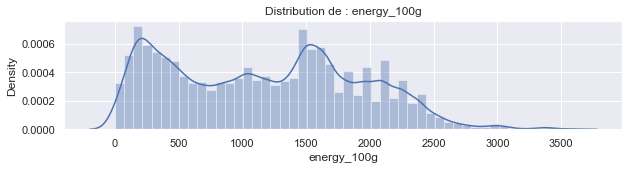

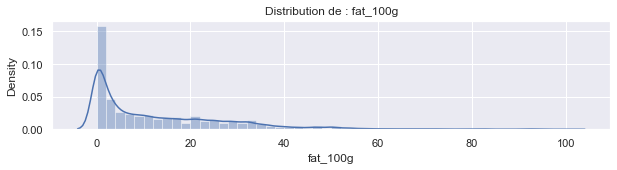

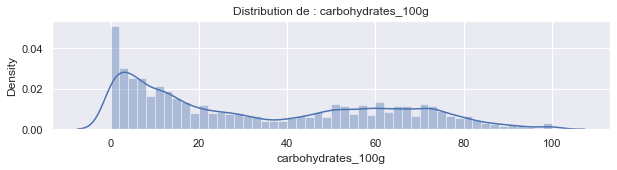

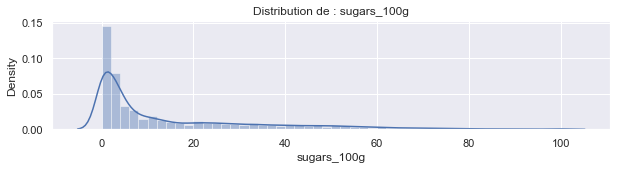

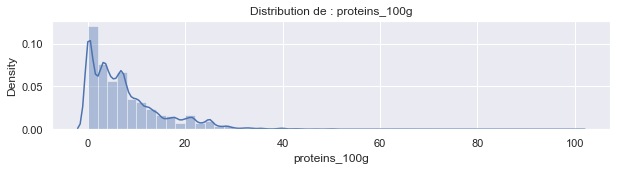

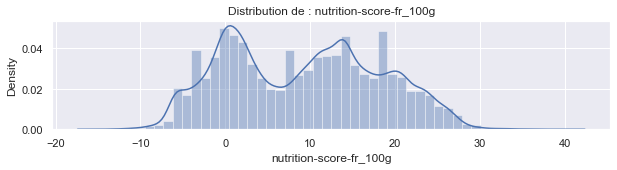

In [715]:
numeric_columns = food_modif_del.select_dtypes(include = ['int32','float64']).columns
for column in numeric_columns:
    plt.figure(figsize = (10,2))
    sns.set(font_scale=1)
    sns.distplot(food_modif_del[column], bins=50)
    chaine = 'Distribution de : ' + column
    plt.title(chaine)
    plt.xlabel(column)
    plt.show()

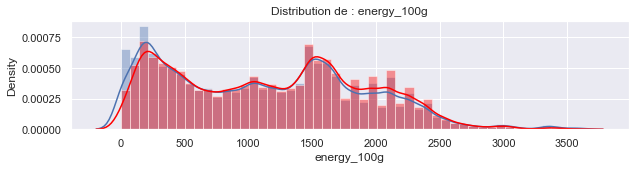

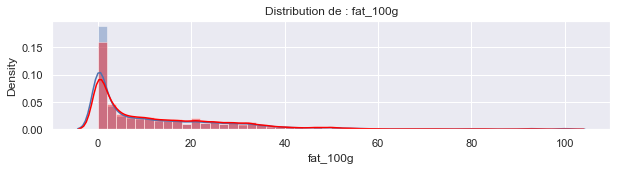

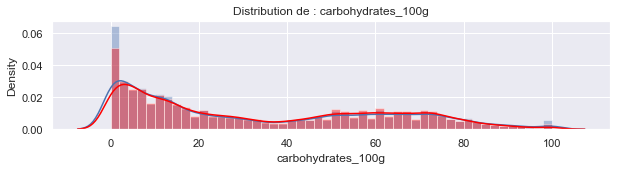

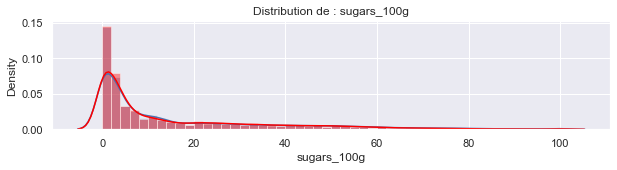

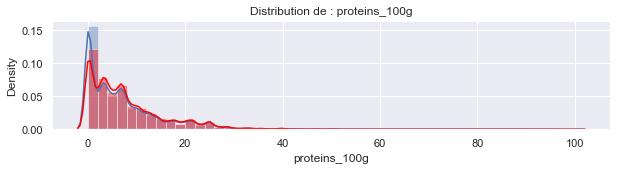

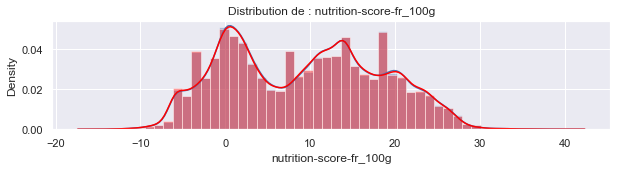

In [716]:
numeric_columns = food_modif.select_dtypes(include = ['int32','float64']).columns
for column in numeric_columns:
    plt.figure(figsize = (10,2))
    sns.set(font_scale=1)
    sns.distplot(food_modif[column], bins=50)
    sns.distplot(food_modif_del[column], bins=50,color= 'red')
    chaine = 'Distribution de : ' + column
    plt.title(chaine)
    plt.xlabel(column)
    plt.show()

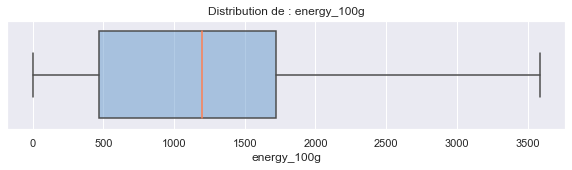

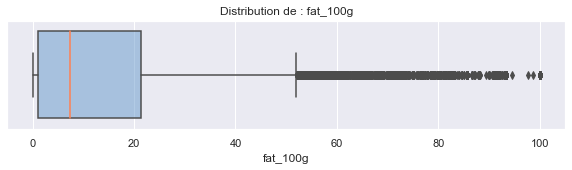

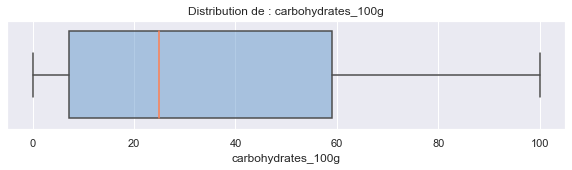

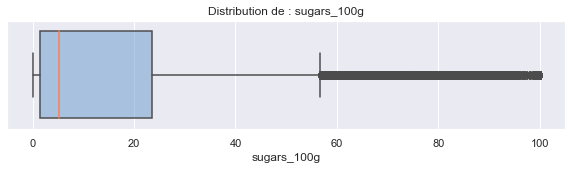

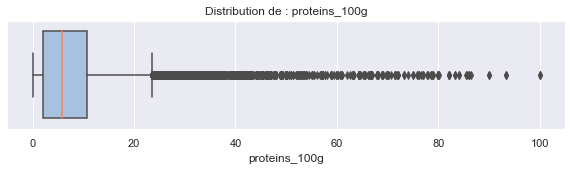

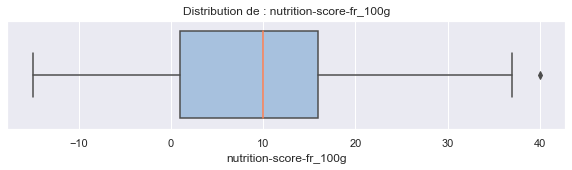

In [717]:
numeric_columns = food_modif_del.select_dtypes(include = ['int32','float64']).columns
for column in numeric_columns:
    plt.figure(figsize = (10,2))
    sns.set(font_scale=1)
    sns.boxplot(x=food_modif_del[column],boxprops={"facecolor": (.4, .6, .8, .5)},medianprops={"color": "coral"})
    chaine = 'Distribution de : ' + column
    plt.title(chaine)
    plt.xlabel(column)
    plt.show()